In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

In [3]:
import NegativeClassOptimization.config as config
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from itertools import combinations

In [4]:
from Bio import motifs
from Bio.Seq import Seq


"""def get_pwm(slides):
    # Create a list of Seq objects
    seqs = [Seq(slide) for slide in slides]

    # Create a motifs instance
    m = motifs.create(seqs, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm: np.ndarray = pd.DataFrame(m.pwm).values
    pwm += 1e-20  # Avoid log(0)

    return pwm"""
def get_pwm(slides_1, slides_2):
    # Create a list of Seq objects
    seqs_1 = [Seq(slide) for slide in slides_1]
    seqs_2 = [Seq(slide) for slide in slides_2]

    # Create a motifs instance
    m_1 = motifs.create(seqs_1, alphabet=config.AMINOACID_ALPHABET) # type: ignore
    m_2 = motifs.create(seqs_2, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm_1: np.ndarray = pd.DataFrame(m_1.pwm).values
    pwm_1 += 1e-20  # Avoid log(0)
    pwm_2: np.ndarray = pd.DataFrame(m_2.pwm).values
    pwm_2 += 1e-20  # Avoid log(0)
    return pwm_1, pwm_2

def jensen_shannon_divergence_slides(slides_1, slides_2):

    pwm_1, pwm_2 = get_pwm(slides_1, slides_2)
    return jensenshannon(pwm_1, pwm_2, axis=1, base=2).sum() 

In [5]:
task_2_folder = {'vs 9':'1v9', 'vs Non-binder':'high_vs_95low', 'vs Weak': 'high_vs_looser', 'vs 1':'1v1'}
tasks = ['vs 9', 'vs Non-binder', 'vs Weak', 'vs 1']

In [6]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

In [7]:
jsds = []
for task in tasks:
    datasets_paths = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_0/split_*/*/*_train_dataset.tsv')
    for path in datasets_paths:
        df = pd.read_csv(path, sep='\t')
        slides_pos = df[df['y'] == 1]['Slide'].to_list()
        slides_neg = df[df['y'] == 0]['Slide'].to_list()
        jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
        train_task = task
        seed = path.split('/')[4].split('_')[1]
        split = path.split('/')[5].split('_')[1]
        if task == 'vs 1':
            train_ag = path.split('/')[6].split('__')[0]
            train_neg = path.split('/')[6].split('__')[2]
            seed = int(path.split('/')[4].split('_')[1])
            split = int(path.split('/')[5].split('_')[1])
        else:
            train_ag = path.split('/')[6].split('__')[0].split('_')[0]
            train_neg = 'auto'

        jsds.append([train_task, jsd, train_ag, train_neg, seed, split])


In [8]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

In [9]:
jsds_df = pd.DataFrame(jsds, columns=["train_task", "jsd", "train_ag", "train_neg", "seed", "split"])

In [10]:
jsds_df_means = jsds_df.groupby(['train_task', 'train_ag', 'train_neg', 'seed']).mean().reset_index()

In [11]:
jsd_by_task = jsds_df_means[jsds_df_means['train_task'] != 'vs 1'].pivot(index='train_ag', columns='train_task', values="jsd").loc[ag_order]

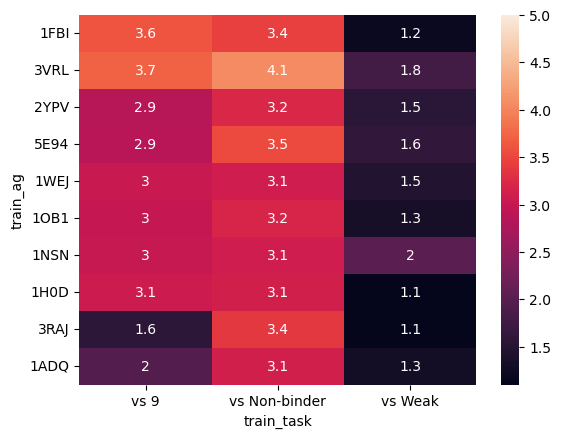

In [12]:
plt.rcParams['svg.fonttype'] = 'none'
sns.heatmap(jsd_by_task, annot=True, vmin=1.1, vmax=5)
plt.savefig('./figures/jsd_task_heatmap.svg')

In [13]:
jsd_ag_vs_ag = jsds_df_means[jsds_df_means['train_task'] == 'vs 1'].pivot(index='train_ag', columns='train_neg', values="jsd").loc[ag_order][ag_order]

In [21]:
jsds_df_means[jsds_df_means['train_task']== 'vs 1'].to_csv('jsd_vs1.csv')

In [14]:
mask = np.triu(jsd_ag_vs_ag)

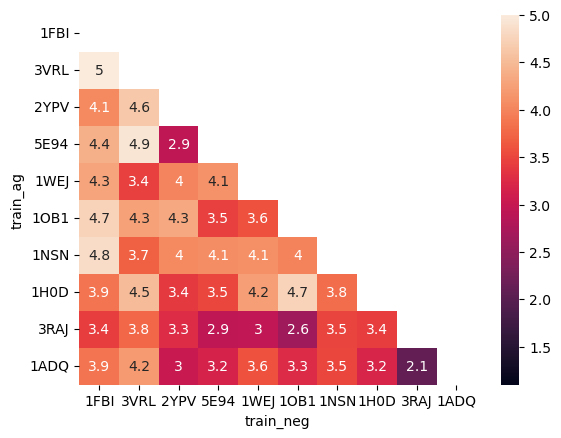

In [15]:
plt.rcParams['svg.fonttype'] = 'none'
sns.heatmap(jsd_ag_vs_ag, annot=True, mask=mask,  vmin=1.1, vmax=5)
plt.savefig('./figures/jsd_ag_triug_heatmap.svg')

## PWM correlation

In [59]:
#calculate pwm for positives of all antigens for a particular split
pos_pwm_flat = dict()
ag_task_pwm_corr = []
for ag in config.ANTIGENS:
    calc = True
    for task in ['vs 9', 'vs Non-binder', 'vs Weak']:
        seed = 0 
        split = 42
        path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_{seed}/split_{split}/{ag}*/*_train_dataset.tsv')[0]
        df = pd.read_csv(path, sep='\t')

        if calc:
            slides_pos = df[df['y'] == 1]['Slide'].to_list() #should be done once
            pos_pwm = get_pwm(slides_pos)
            calc = False
            pos_pwm_flat[ag] = pos_pwm.flatten()
        pos_pwm = pos_pwm_flat[ag]
        slides_neg = df[df['y'] == 0]['Slide'].to_list()
        neg_pwm = get_pwm(slides_neg)
        neg_pwm = neg_pwm.flatten()
        p, pval = pearsonr(pos_pwm, neg_pwm)
        ag_task_pwm_corr.append([ag, task, p, pval])


In [60]:
df_pwm_corr = pd.DataFrame(ag_task_pwm_corr, columns=["ag", "task", "P_corr", "pval"])


In [1]:
task = 'vs Non-binder'
n = int(15000 * 0.4) # I am taking 30% positive/negative data with extreme binding energies
ag_exta_nb_pwm_corr = []
for ag in config.ANTIGENS:    
    path_nb_eng = glob.glob(f'../data/full_data/divided2classes/{ag}*/{ag}_[A-Z]_500kNonMascotte.txt')[0]
    path_pos_eng = glob.glob(f'../data/full_data/divided2classes/{ag}*/{ag}_[A-Z]_MascotteSlices.txt')[0]
    path_weak_eng = glob.glob(f'../data/full_data/divided2classes/{ag}*/{ag}_[A-Z]_LooserExclusiveSlices.txt')[0]


    path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_{seed}/split_{split}/{ag}*/*_train_dataset.tsv')[0]
    df = pd.read_csv(path, sep='\t')
    df_eng_pos = pd.read_csv(path_pos_eng, sep='\t', header=1)
    df_eng_nb = pd.read_csv(path_nb_eng, sep='\t', header=1)
    df_eng_weak = pd.read_csv(path_weak_eng, sep='\t', header=1)
    df_eng = pd.concat([df_eng_pos,  df_eng_nb,  df_eng_weak])[['Slide', 'Energy']]
    df = df.merge(df_eng, on='Slide', how='left')
    df.sort_values('Energy', inplace=True)
    #df_extra_pos = df.iloc[:n]
    df_extra_pos = df # changed
    df_extra_pos = df_extra_pos[df_extra_pos["y"] == 1]
    df_extra_neg = df.iloc[-n:]
    df_extra_neg = df_extra_neg[df_extra_neg["y"] == 0]

    slides_pos = df_extra_pos[df_extra_pos['y'] == 1]['Slide'].to_list() #should be done once
    pos_pwm = get_pwm(slides_pos)
    pos_pwm = pos_pwm_flat[ag]
    slides_neg = df_extra_neg[df_extra_neg['y'] == 0]['Slide'].to_list()
    neg_pwm = get_pwm(slides_neg)
    neg_pwm = neg_pwm.flatten()
    p, pval = pearsonr(pos_pwm, neg_pwm)
    ag_exta_nb_pwm_corr.append([ag, 'extra binder/nb', p, pval])

NameError: name 'config' is not defined

In [77]:
df_extra_pwm_corr = pd.DataFrame(ag_exta_nb_pwm_corr, columns=["ag", "task", "P_corr", "pval"])
df_pwm_corr_full = pd.concat([df_pwm_corr,df_extra_pwm_corr])

<AxesSubplot:xlabel='task', ylabel='ag'>

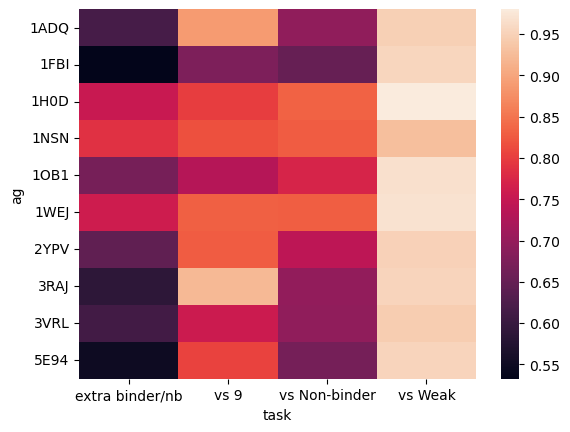

In [78]:
sns.heatmap(df_pwm_corr_full.pivot(index='ag', columns='task', values="P_corr"))

In [83]:
#let's try 1v1
pwm_corr_1v1 = []
ag_comb = list(combinations(config.ANTIGENS, 2))
for ag1, ag2 in ag_comb:
    p, pval = pearsonr(pos_pwm_flat[ag1], pos_pwm_flat[ag2])
    pwm_corr_1v1.append([ag1, ag2, p, pval])
df_pwm_corr_1v1 = pd.DataFrame(pwm_corr_1v1, columns=["ag1", "ag2", "P_corr", "pval"])

In [90]:
df_pwm_corr_1v1 = df_pwm_corr_1v1.pivot(index='ag1', columns='ag2', values='P_corr')
row_non_null_counts = df_pwm_corr_1v1.notnull().sum(axis=1)
col_non_null_counts = df_pwm_corr_1v1.notnull().sum(axis=0)

# Sort index and columns by these counts
sorted_rows = row_non_null_counts.sort_values(ascending=True).index
sorted_cols = col_non_null_counts.sort_values(ascending=False).index

# Rearrange the DataFrame
df_pwm_corr_1v1 = df_pwm_corr_1v1.loc[sorted_rows, sorted_cols]

<AxesSubplot:xlabel='ag2', ylabel='ag1'>

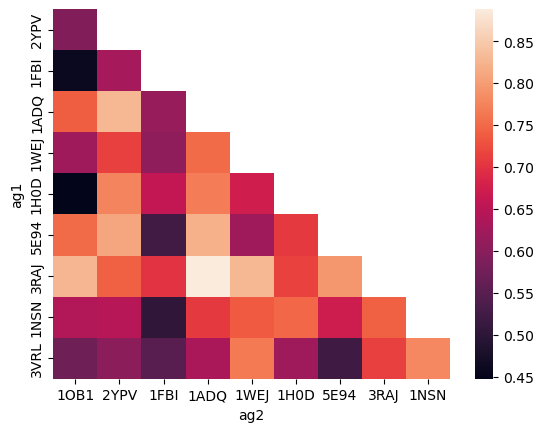

In [94]:
sns.heatmap(df_pwm_corr_1v1)

In [97]:
df_1vs1_perf = pd.read_csv('../data/1vs1_perf.tsv', sep='\t', index_col=0)

In [105]:
df_1v1_perf_pivot = df_1vs1_perf.groupby(['train_ag', 'train_neg']).mean('acc').reset_index().pivot(index='train_ag', columns='train_neg', values='acc')

<AxesSubplot:xlabel='train_neg', ylabel='train_ag'>

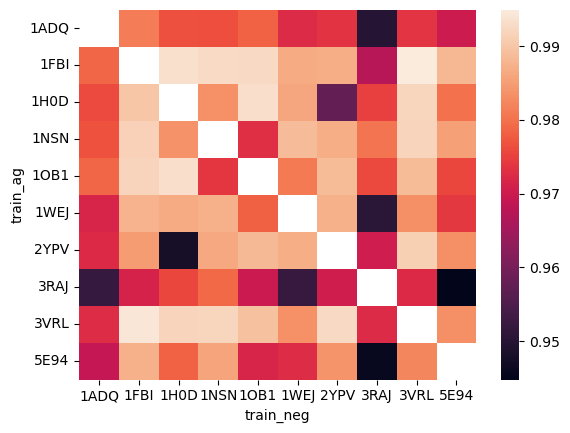

In [106]:
sns.heatmap(df_1v1_perf_pivot)

In [119]:
perfs = np.tril(df_1v1_perf_pivot.loc[sorted_rows, sorted_cols]).flatten()

In [126]:
perfs = perfs[perfs!=0]
pwm_corr = pwm_corr[pwm_corr!=0]

In [134]:
pearsonr(perfs, pwm_corr)

(-0.6600589621281592, 8.113162846709001e-07)

<AxesSubplot:>

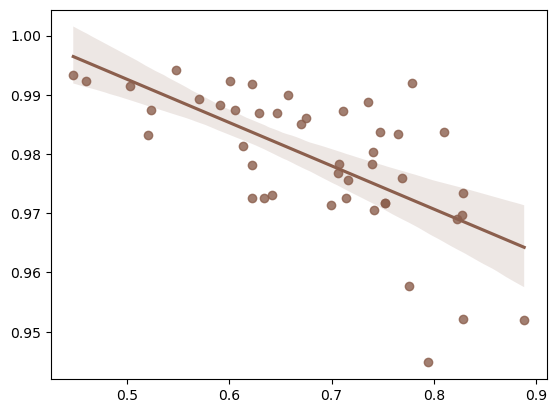

In [170]:
sns.regplot(y=perfs, x=pwm_corr, color='#8B5F4D')

In [137]:
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')

In [143]:
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])

In [148]:
perf_df_id = perf_df[perf_df['train_task'] == perf_df['test_task']]

In [159]:
perf_df_id_mean = perf_df_id.groupby(['train_ag', 'train_task']).mean().reset_index()

In [161]:
df_pwm_acc_corr = df_pwm_corr.merge(perf_df_id_mean, how='left', left_on=['ag', 'task'], right_on=['train_ag', 'train_task'])

In [162]:
df_pwm_acc_corr.head()

,ag,task,P_corr,pval,train_ag,train_task,acc,recall,precision,f1
0,3VRL,vs 9,0.756505,4.427095e-42,3VRL,vs 9,0.973087,0.977533,0.968950,0.973218
1,3VRL,vs Non-binder,0.695195,4.279596e-33,3VRL,vs Non-binder,0.996600,0.998467,0.994754,0.996607
2,3VRL,vs Weak,0.944793,1.322494e-107,3VRL,vs Weak,0.952211,0.961311,0.944142,0.952643
3,1NSN,vs 9,0.816006,8.450138e-54,1NSN,vs 9,0.959013,0.955200,0.962582,0.958870
4,1NSN,vs Non-binder,0.826877,2.093837e-56,1NSN,vs Non-binder,0.978000,0.982156,0.974065,0.978091


In [190]:
r, pval = pearsonr(perfs, pwm_corr)

In [ ]:
x = perfs.mean()
y = pwm_corr.mean()
r, pval = pearsonr(perfs, pwm_corr)
ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}")

-0.6600589621281592 0.43567783348570266 8.113162846709001e-07


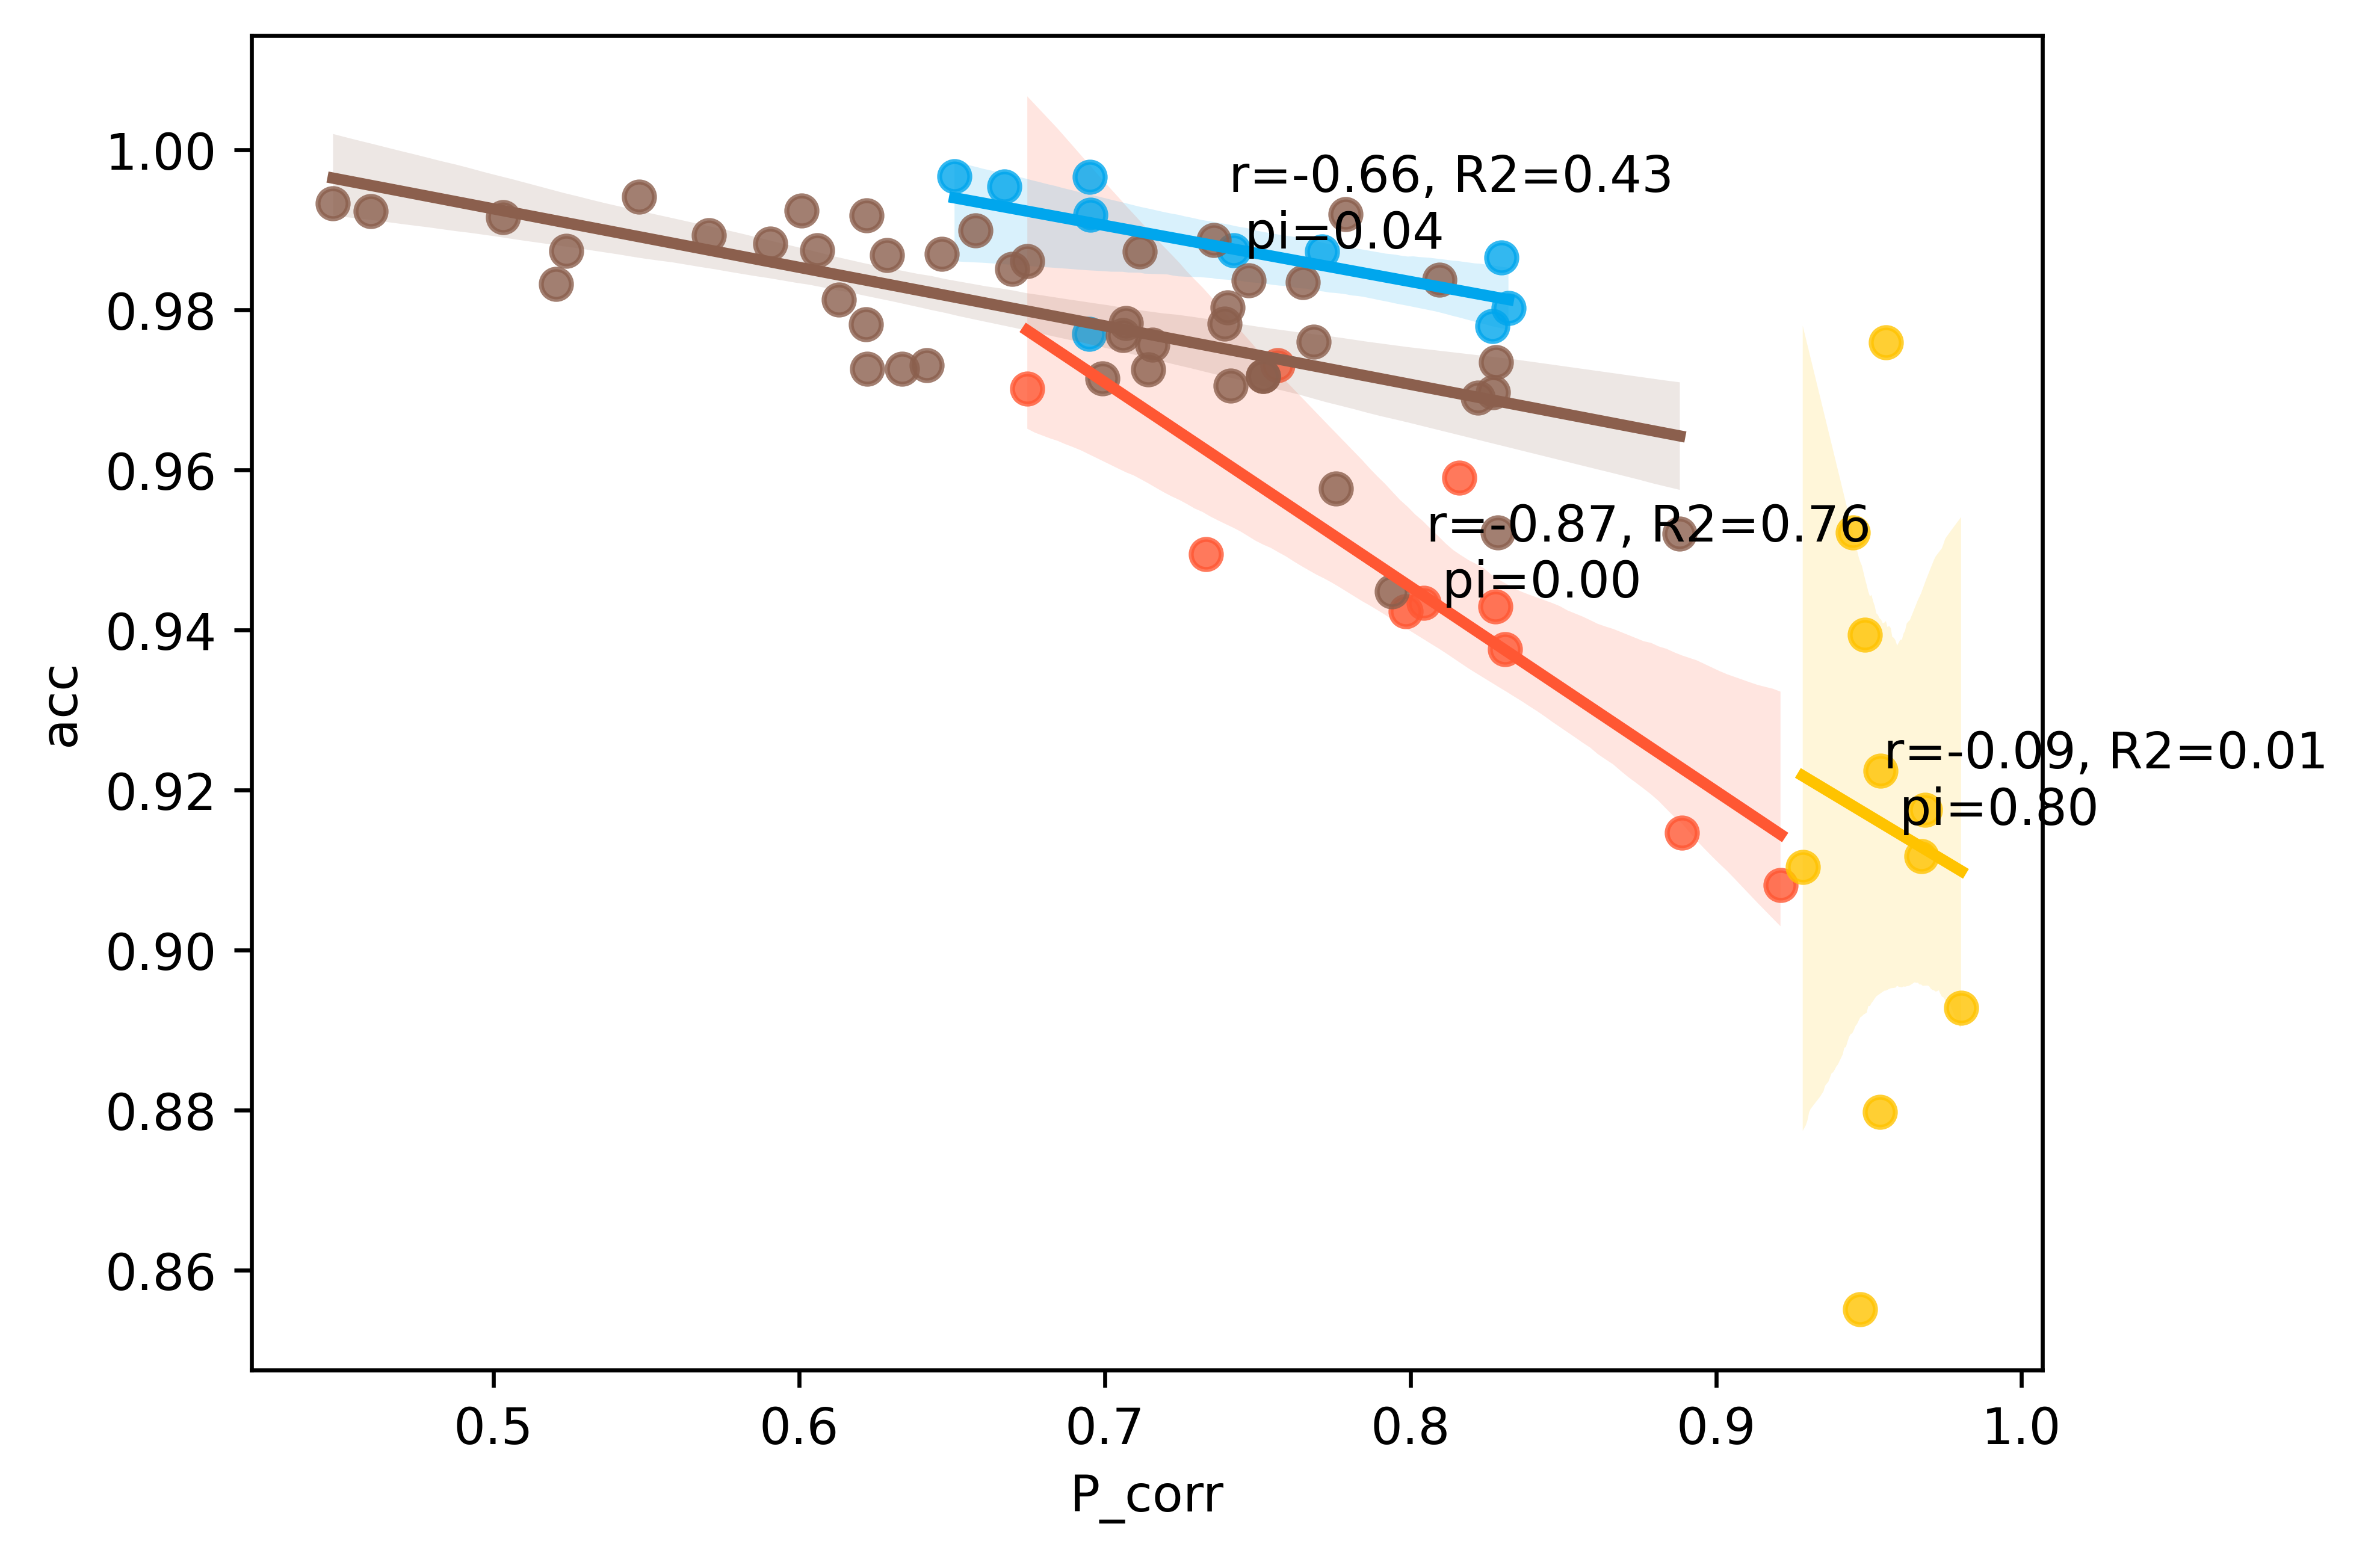

In [196]:
fig, ax = plt.subplots( dpi=600)
for task in  ['vs 9', 'vs Non-binder', 'vs Weak']:
    df = df_pwm_acc_corr[df_pwm_acc_corr['task']== task]
    sns.regplot(x=df['P_corr'], y=df['acc'], ax=ax, color=cmap[task], label=task, scatter=True)
    r, pval = pearsonr(df['P_corr'], df['acc'])
    # Add text with r and R2 at centroid
    x = df['P_corr'].mean()
    y = df['acc'].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}")
sns.regplot(y=perfs, x=pwm_corr, color='#8B5F4D', ax=ax,  label=task, scatter=True)
r, pval = pearsonr(perfs, pwm_corr)
print(r, r**2, pval)
plt.savefig('./figures/pwm_corr_vs_acc.svg')

In [202]:
r, pval = pearsonr(perfs, pwm_corr)

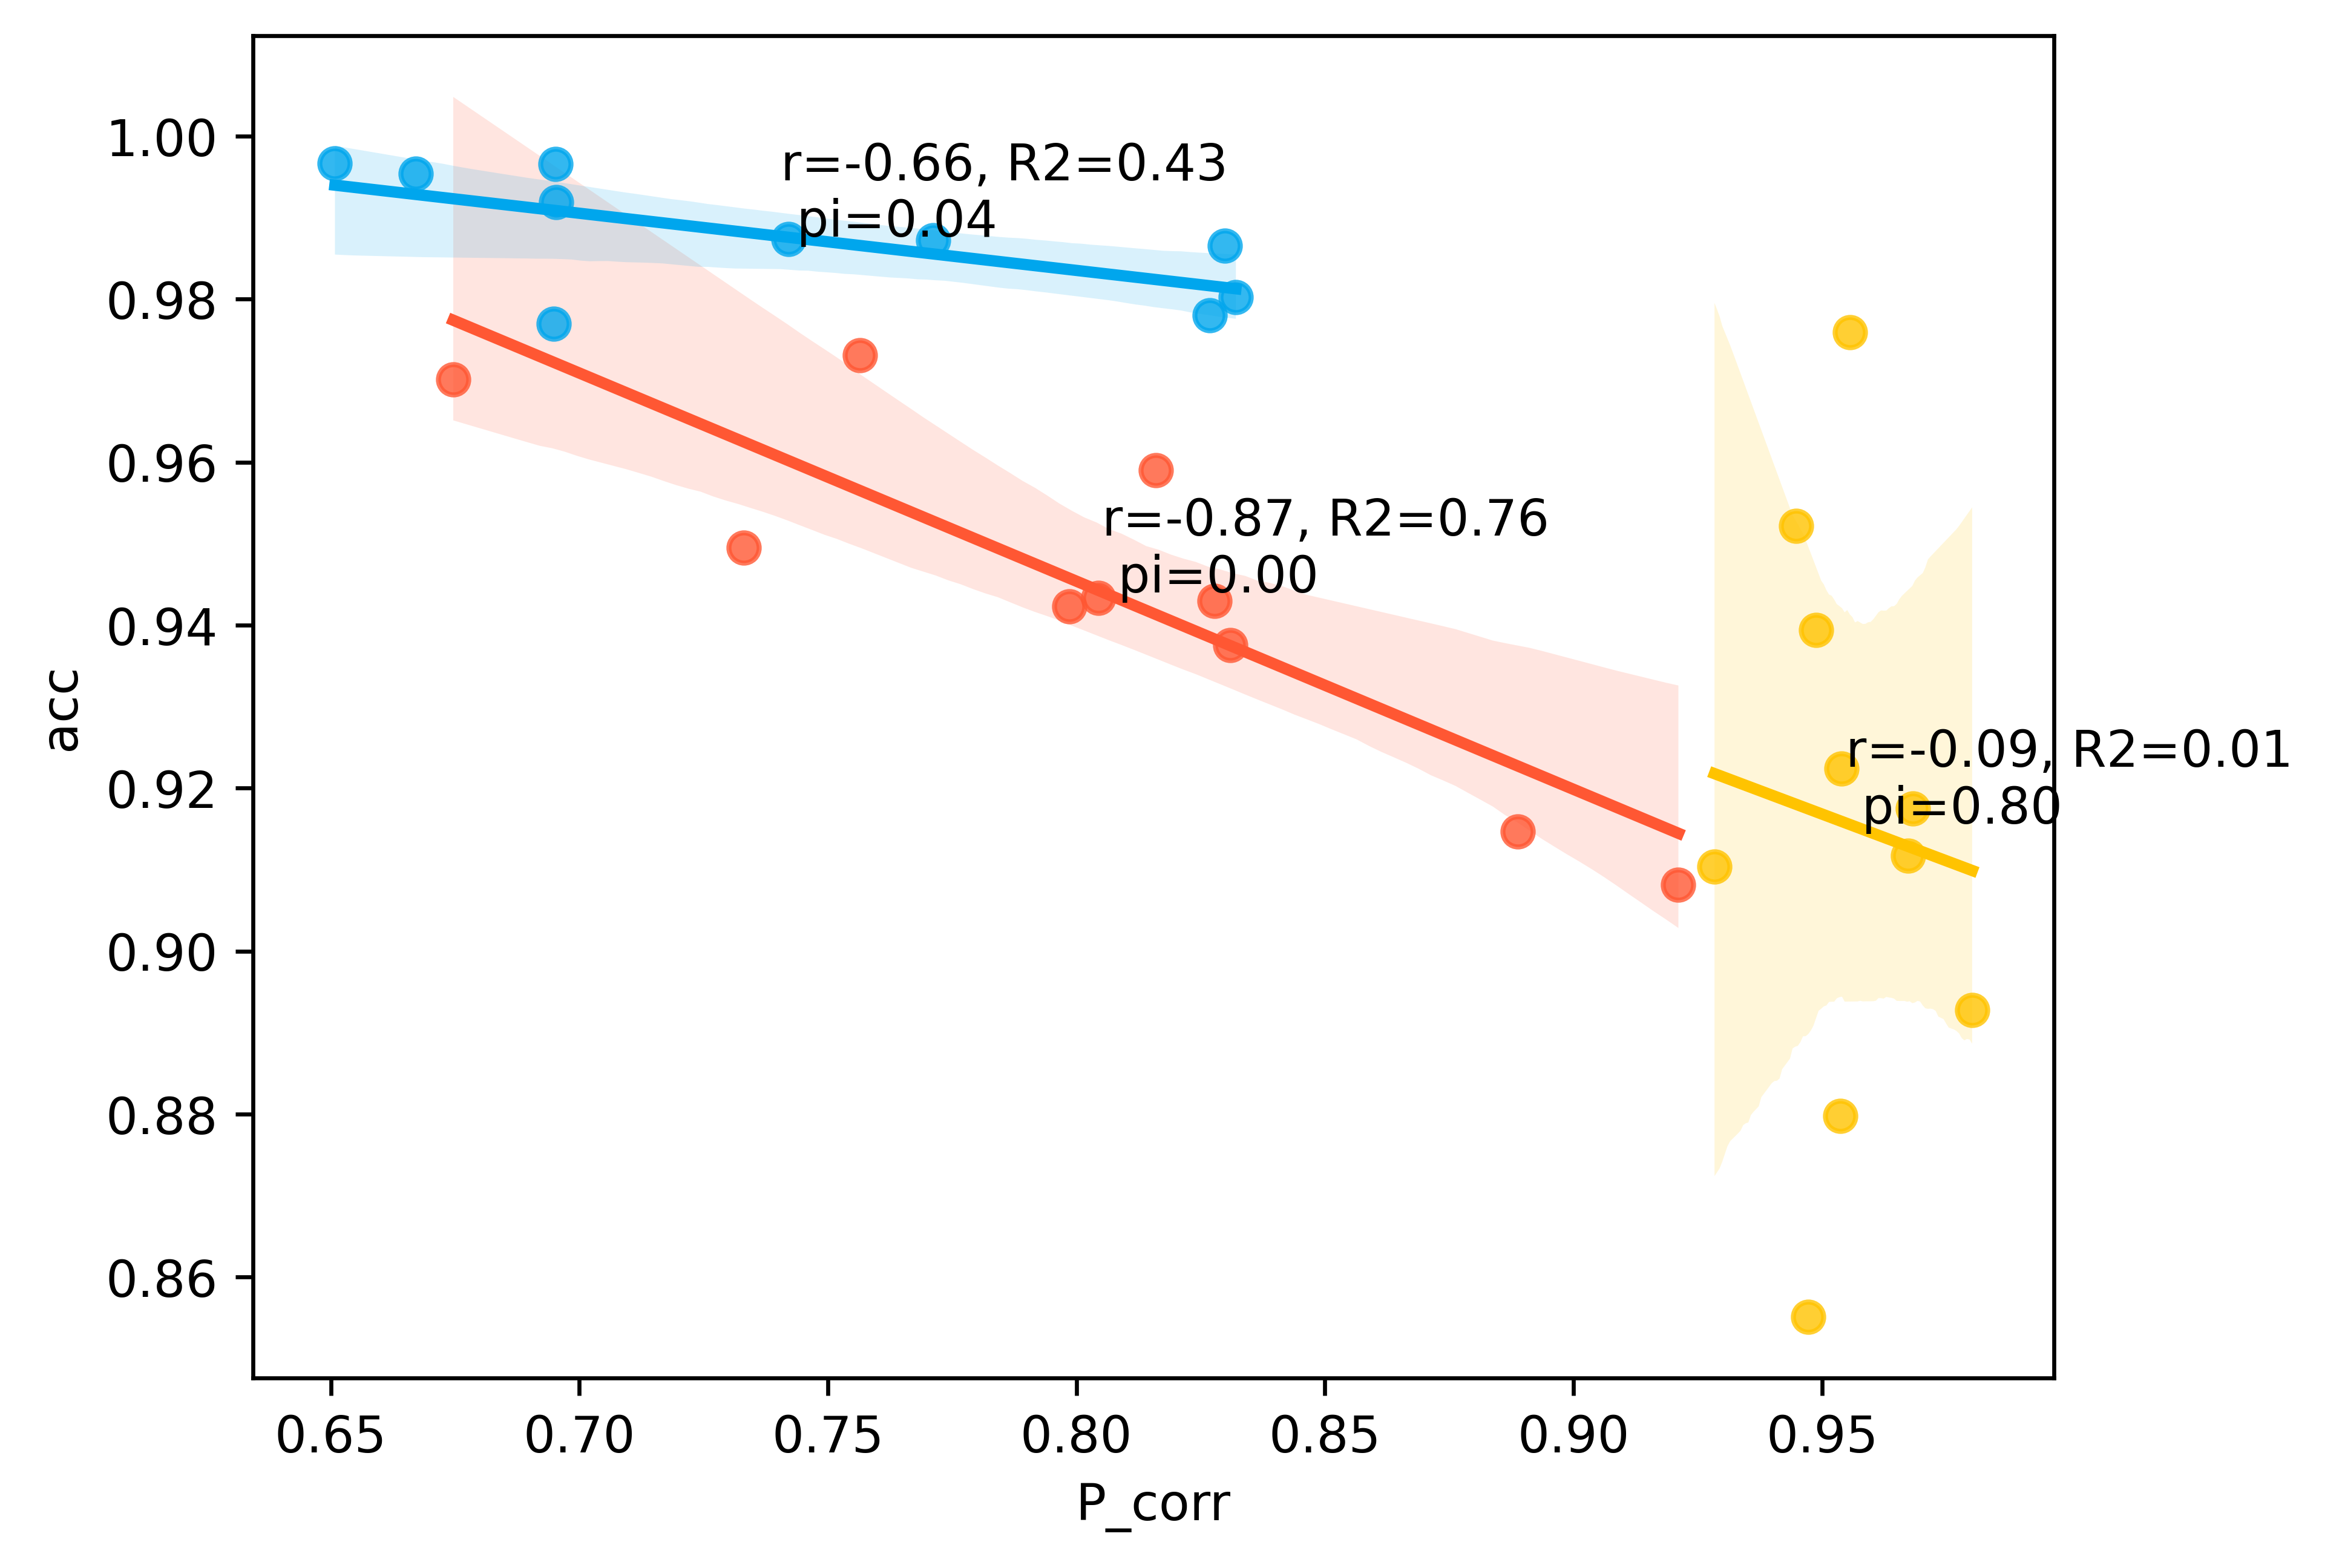

In [200]:
fig, ax = plt.subplots( dpi=600)
for task in  ['vs 9', 'vs Non-binder', 'vs Weak']:
    df = df_pwm_acc_corr[df_pwm_acc_corr['task']== task]
    sns.regplot(x=df['P_corr'], y=df['acc'], ax=ax, color=cmap[task], label=task, scatter=True)
    r, pval = pearsonr(df['P_corr'], df['acc'])
    # Add text with r and R2 at centroid
    x = df['P_corr'].mean()
    y = df['acc'].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}")